# E17_Multiclass
---

## Environment Setting
---

In [36]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import math
import numpy as np
import tensorflow as tf
import keras
import h5py
from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

import seaborn as sns
sns.set(style='white')
sns.set_context('paper')

env: SM_FRAMEWORK=tf.keras


In [37]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [38]:
FILE_PATH = '/home/aiffel-dj1/workspace/Hackerton/workspace/Model/data/LV2_PNG_DATASET_OSM.h5'
BASE_TARIN_DIR = "/train"
TRAIN_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/img'
TRAIN_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/label'
TRAIN_SPLIT_DIR = f'{Path(BASE_TARIN_DIR)}/split'  
TRAIN_SPLIT_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/split/img'           
TRAIN_SPLIT_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/split/label'                                                                                                                         

BASE_VAL_DIR = "/val"
VAL_IMG_PATH = f'{Path(BASE_VAL_DIR)}/img'
VAL_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/label'
VAL_SPLIT_DIR = f'{Path(BASE_VAL_DIR)}/split'  
VAL_SPLIT_IMG_PATH = f'{Path(BASE_VAL_DIR)}/split/img'           
VAL_SPLIT_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/split/label' 

BASE_TEST_DIR = "/test"
TEST_SPLIT_DIR = f'{Path(BASE_TEST_DIR)}/split'  
TEST_SPLIT_IMG_PATH = f'{Path(BASE_TEST_DIR)}/split/img'           
TEST_SPLIT_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/split/label'  

IMAGE_SIZE = 1024
IMG_CHANNELS = 3

COLOR_MAP = [
    (165, 42, 42),
    (0, 192, 0),
    (255,255,255)
]

### dataset 확인

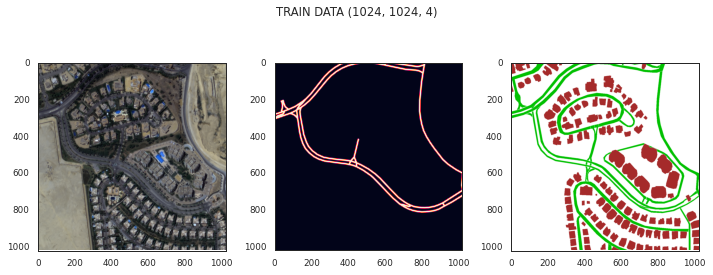

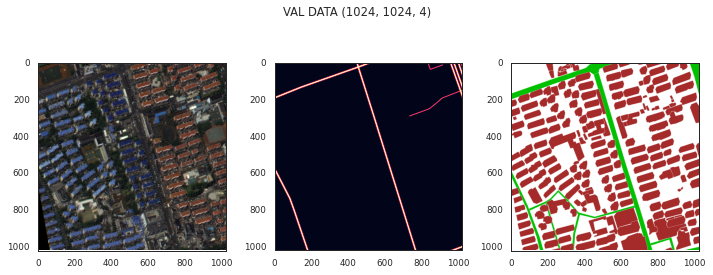

In [39]:
import matplotlib.pyplot as plt
i = 0
with h5py.File(FILE_PATH, 'r') as hdf5_file:
    plt.figure(figsize=(10,4))
    plt.suptitle(f'TRAIN DATA {hdf5_file[TRAIN_IMG_PATH][i].shape}')
    plt.subplot(131)
    plt.imshow(hdf5_file[TRAIN_IMG_PATH][i][:,:,:3])
    plt.subplot(132)
    plt.imshow(hdf5_file[TRAIN_IMG_PATH][i][:,:,3])
    plt.subplot(133)
    plt.imshow(hdf5_file[TRAIN_LABEL_PATH][i])
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10,4))
    plt.suptitle(f'VAL DATA {hdf5_file[TRAIN_IMG_PATH][i].shape}')
    plt.subplot(131)
    plt.imshow(hdf5_file[VAL_IMG_PATH][i][:,:,:3])
    plt.subplot(132)
    plt.imshow(hdf5_file[VAL_IMG_PATH][i][:,:,3])
    plt.subplot(133)
    plt.imshow(hdf5_file[VAL_LABEL_PATH][i])
    plt.tight_layout()
    plt.show()

## Functions
---

### Split

In [40]:
import random

def get_slice_pos(split_cnt, slice_type='sliding', stride_size=192, input_size=256, img_size=1024):
    pts = []
    
    if slice_type == 'sliding':
        n = math.sqrt(split_cnt)
        for slice_pos in range(split_cnt):
            pos_i = int(math.floor(slice_pos / n))
            pos_j = int(slice_pos % int(n))
            
            x = stride_size * pos_i
            y = stride_size * pos_j
            
            pts.append((x, x+input_size, y, y+input_size))
            
    elif slice_type =='crop':
        random.seed(2)
        get_random_point = lambda: random.randint(0, img_size-input_size)
        
        for _ in range(split_cnt):
            x = get_random_point()
            y = get_random_point()
            pts.append((x, x+input_size, y, y+input_size))
            
    return pts

In [41]:
def split_png(img, pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
    return sub_imgs

In [42]:
def save_png_imgs_labels(dataset, i, imgs, labels):
    for img, label in zip(imgs, labels):
        dataset['img'][i, ...] = img
        dataset['label'][i, ...] = label
        i += 1
    return i

In [43]:
def filtering(imgs, labels, threshold=1, img_size=256):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    하지만, threshold 미만은 모든 데이터를 지우는 것은 데이터 학습의 효율을 떨어뜨릴 수 있으므로,
    이 과정에 확률을 넣어 (면적 차지 비율)% 확률로 threshold 미만의 데이터가 필터링 되지 않도록 한다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float): 라벨에 포한된 1의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    rand = lambda x: np.random.choice([0, 1], 1, p=[1-(x/100), x/100])[0]

    label_areas = [label[:,:,-1].sum() for label in labels]
    label_areas = np.array([256*256 - area for area in label_areas])
    rates = label_areas / (img_size * img_size) * 100
    filter_mask = [True if rate > threshold else rand(rate) for rate in rates]
    
    filtered_imgs = [img for img, mask in zip(imgs, filter_mask) if mask]
    filtered_labels = [label for label, mask in zip(labels, filter_mask) if mask]
    return filtered_imgs, filtered_labels

In [44]:
def split_filtering_save(filtering_fun, FILE_PATH, BASE_DIR, IMG_PATH, LABEL_PATH, 
                         COLOR_MAP, img_size=256, split_cnt=25, threshold=1):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float)
            - 라벨에 포한된 1의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.
            - 만약 0이 주어진다면 모든 이미지를 필터링 없이 저장한다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    start_time = time.time()
    with h5py.File(FILE_PATH, "a") as f:
        # create split dataset ex. FILE[train][split][img], FILE[train][split][label]
        size = f[IMG_PATH].shape[0] * split_cnt
        if 'split' in f[BASE_DIR].keys(): del f[BASE_DIR]['split']
        f[BASE_DIR].create_group('split')
        img_ds = f[BASE_DIR]['split'].create_dataset('img', (size, img_size, img_size, 4), np.uint8, maxshape=(size, img_size, img_size, 4))
        lable_ds = f[BASE_DIR]['split'].create_dataset('label', (size, img_size, img_size, 3), np.float32, maxshape=(size, img_size, img_size, 3))
        
        if threshold > 0:
            pts = get_slice_pos(split_cnt, 'crop')
        else:
            pts = get_slice_pos(split_cnt, 'sliding')
                
        sub_idx = 0
        for i in tqdm(range(f[IMG_PATH].shape[0])):           
            # split img with pts(left-top points)
            sub_imgs = split_png(f[IMG_PATH][i], pts)
            
            # extract binary mask from label
            masks = [(f[LABEL_PATH][i] == v) for v in COLOR_MAP]
            mask = [(mask[:,:,0] * mask[:,:,1] * mask[:,:,2]) for mask in masks]
            mask = np.stack(mask, axis=-1).astype(np.float32)
            
             # split mask with pts
            sub_labels = split_png(mask, pts)
            
            # filtering labels.
            # after this, the label ratio of less than threshold is filtered out.
            filtered_imgs, filtered_labels = filtering_fun(sub_imgs, sub_labels, threshold=threshold, img_size=img_size)
            
            # save imgs and labels in split dataset
            filted_img_size = len(filtered_imgs)
            img_ds[sub_idx:sub_idx+filted_img_size, ...] = filtered_imgs
            lable_ds[sub_idx:sub_idx+filted_img_size, ...] = filtered_labels
            sub_idx += filted_img_size
            
        # resize dataset
        img_ds.resize((sub_idx, img_size, img_size, 4))
        lable_ds.resize((sub_idx, img_size, img_size, 3))

### 라벨 이미지내 면적 분포확인

In [45]:
def show_area_distributaion(FILE_PATH, DIR_PATH):
    with h5py.File(FILE_PATH, "r") as f:
        img_size = f[DIR_PATH].shape[0]
        building_areas = np.sum(f[DIR_PATH], axis=1)
        building_areas = np.sum(building_areas, axis=1)

    print(f'min: {building_areas.min()}, max: {building_areas.max()}')
    plt.figure(figsize=(12,5))
    sns.histplot(building_areas, bins=100)
    plt.show()

In [46]:
def show_area_rate_distributaion(FILE_PATH, DIR_PATH):
    with h5py.File(FILE_PATH, "r") as f:
        building_areas = np.sum(f[DIR_PATH], axis=1)
        building_areas = np.sum(building_areas, axis=1)
        building_areas_rate = building_areas / (256*256) * 100
        
    print(f'min: {building_areas_rate.min()}%, max: {building_areas_rate.max()}%')
    plt.figure(figsize=(12,5))
    sns.histplot(building_areas_rate, bins=100)
    plt.show()

### Utility

In [12]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [13]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

### Dataset

In [14]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [15]:
class SatelliteGenerator(tf.keras.utils.Sequence):
    '''
    ref: https://github.com/AIFFEL-FREESIA/Model/blob/master/Unet_building_256_2.ipynb
    SatelliteGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    '''
    def __init__(self, 
                 filepath,
                 x_path,
                 y_path,
                 batch_size=8,
                 augmentation=None, 
                 preprocessing=None,
                 is_train=True):
        
        self.filepath = filepath
        self.x_path = x_path
        self.y_path = y_path
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.size = 0
        with h5py.File(self.filepath, 'r') as f:
            self.size = f[x_path].shape[0]
            
        self.batch_size = batch_size
        self.is_train = is_train
    
    def __len__(self):
        return math.ceil(self.size / self.batch_size)

    def __getitem__(self, index):
        with h5py.File(self.filepath, 'r') as f:
            images = f[self.x_path][index*self.batch_size : (index + 1)*self.batch_size]
            masks = f[self.y_path][index*self.batch_size : (index + 1)*self.batch_size]
            res = [(img, mask) for img, mask in zip(images, masks)]

            if self.augmentation:
                res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            if self.preprocessing:
                res = [self.preprocessing(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            
            images = np.array([img for img, _ in res ])
            masks = np.array([mask for _, mask in res ])
            
            return images, masks

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(self.size)
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

### Train

In [16]:
def get_datagenerator(BATCH_SIZE=8, BACKBONE='efficientnetb3'):
    # Dataset for train images
    preprocess_input = sm.get_preprocessing(BACKBONE)
    train_datagenerator = SatelliteGenerator(
        FILE_PATH,
        TRAIN_SPLIT_IMG_PATH,
        TRAIN_SPLIT_LABEL_PATH,
        batch_size=BATCH_SIZE,
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=True
    )

    # Dataset for validation image
    valid_datagenerator = SatelliteGenerator(
        FILE_PATH,
        VAL_SPLIT_IMG_PATH, 
        VAL_SPLIT_LABEL_PATH, 
        batch_size=BATCH_SIZE,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=False
    )

    return train_datagenerator, valid_datagenerator

In [17]:
import time
import datetime
def logging_time(original_fn):
    def wrapper_fn(*args, **kwargs):
        start_time = time.time()
        
        result = original_fn(*args, **kwargs)
        
        sec = time.time()-start_time
        times = str(datetime.timedelta(seconds=sec)).split(".")
        times = times[0]
        print(f'WorkingTime : {times}')
        return result
    return wrapper_fn

In [18]:
def get_model(model_name, optim, train, valid, MODEL_PATH, patience=5):
    BACKBONE = 'efficientnetb3'
    CLASSES = ['building']

    # define network parameters
    n_classes = 3
    activation = 'sigmoid' if n_classes == 1 else 'softmax'

    #create model
    tf.random.set_seed(2)
    model = sm.Unet(BACKBONE, 
                    input_shape=(None,None,4),
                    encoder_weights=None,
                    classes=n_classes, 
                    activation=activation)

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)
    
    log_dir = f"../../logs/E17/{model_name}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks = [
        keras.callbacks.ModelCheckpoint(MODEL_PATH, save_weights_only=True, save_best_only=True, mode='min', monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(verbose=1),
        tensorboard_callback,
        keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    ]
    
    return model, callbacks

In [19]:
def show_history_plot(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    keys = [('loss', 'val_loss'), ('iou_score', 'val_iou_score'), ('f1-score', 'val_f1-score')]
    
    for (train, val), ax in zip(keys, axes):
        ax.plot(history[train])
        ax.plot(history[val])
        ax.set_title(f'Model {train}')
        ax.set_ylabel(train)
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [82]:
def merge_img(sub_imgs, pts):
    merged = np.zeros((1024, 1024, 3))
    seg_map = np.zeros((1024, 1024))
    for i, (x0, x1, y0, y1) in enumerate(pts):
        sub_a = merged[x0:x1, y0:y1, :]
        sub_b = sub_imgs[i]
        added = np.where(sub_a > sub_b, sub_a, sub_b)
        
        reduced = np.argmax(added, axis=-1)
        merged[x0:x1, y0:y1, :] = added
        seg_map[x0:x1, y0:y1] = reduced
    return seg_map

In [121]:
def coloring_seg_map(seg_map):
    color_map = np.stack([seg_map,seg_map,seg_map], axis=-1)
    color_map = np.where(color_map == 0, COLOR_MAP[0], color_map)
    color_map = np.where(color_map == 1, COLOR_MAP[1], color_map)
    color_map = np.where(color_map == 2, COLOR_MAP[2], color_map).astype(np.uint8)
    return color_map

In [116]:
def inference(model, img, crop_pts):
    preprocessing = A.Compose([
        A.Lambda(image=sm.get_preprocessing(BACKBONE)),
    ])
    
    sub_imgs = split_png(img, crop_pts)
    sub_imgs = [preprocessing(image=img)['image'] for img in sub_imgs]

    sub_imgs = [np.expand_dims(img, axis=0) for img in sub_imgs]
    predict_imgs = [model.predict(img) for img in sub_imgs]
    predict_imgs = [predict.squeeze() for predict in predict_imgs]
    
    merged_img = merge_img(predict_imgs, crop_pts)
    return merged_img

In [122]:
def show_inference(model, pts):
    with h5py.File(FILE_PATH, "r") as f:
        for idx in range(5):
            img = f[VAL_IMG_PATH][idx]
            
            predicted = inference(model, img, pts)
            predicted = coloring_seg_map(predicted)
            visualize(
                image=img[:,:,:3],
                ground_truth=f[VAL_LABEL_PATH][idx],
                predicted=predicted
            )

In [24]:
def save_lv2_tset_sample(idx, model, pts, path):
    with h5py.File(FILE_PATH, "r") as f:
        img = f[TEST_IMG_PATH][idx]            
        predicted = (inference(model, img, pts) * 255).astype(np.uint8)
        cv2.imwrite(path, predicted)

## Split
---

In [25]:
def show_n_imgs(PATH, n, x, y):
    with h5py.File(FILE_PATH, "a") as f:
        idx = 0
        imgs = f[PATH][idx*n:idx*n+n]
        plt.figure(figsize=(6, 6))
        for i, sub_img in enumerate(imgs):
            plt.subplot(x, y, i+1)
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            plt.imshow(sub_img[:,:,:3])

        plt.tight_layout()
        plt.show()

### Train

In [26]:
split_filtering_save(filtering, FILE_PATH, BASE_TARIN_DIR, TRAIN_IMG_PATH, TRAIN_LABEL_PATH,
                     COLOR_MAP)

100%|██████████| 324/324 [01:23<00:00,  3.87it/s]


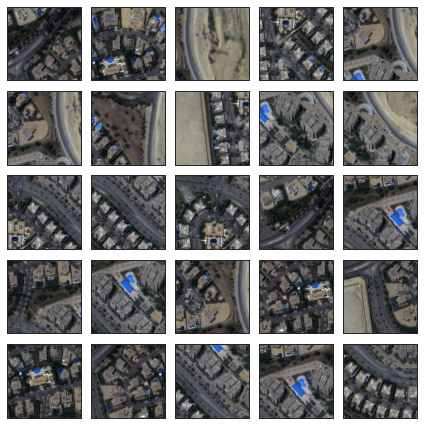

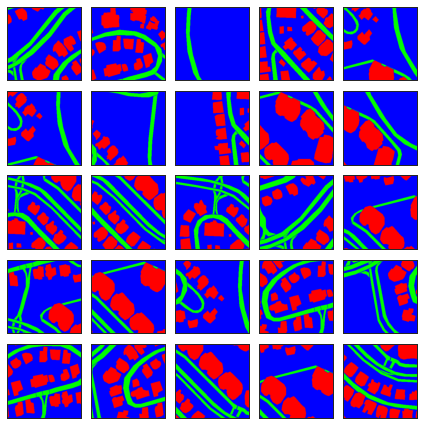

In [28]:
show_n_imgs(TRAIN_SPLIT_IMG_PATH, 25, 5, 5)
show_n_imgs(TRAIN_SPLIT_LABEL_PATH, 25, 5, 5)

min: 0.0, max: 65536.0


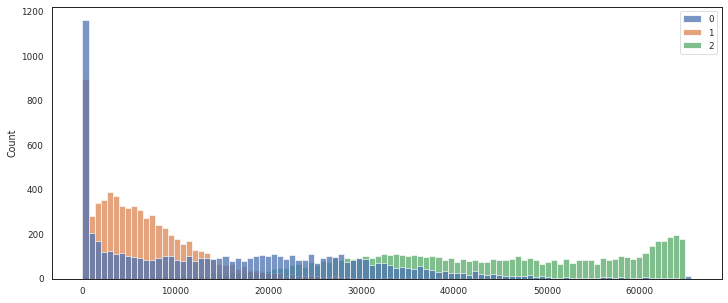

In [126]:
show_area_distributaion(FILE_PATH, TRAIN_SPLIT_LABEL_PATH)

### Val

In [29]:
split_filtering_save(filtering, FILE_PATH, BASE_VAL_DIR, VAL_IMG_PATH, VAL_LABEL_PATH,
                     COLOR_MAP)

100%|██████████| 30/30 [00:04<00:00,  6.01it/s]


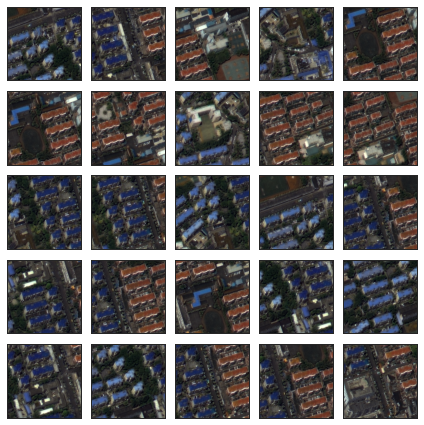

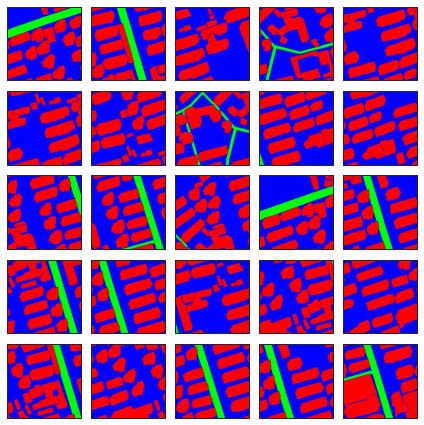

In [30]:
show_n_imgs(VAL_SPLIT_IMG_PATH, 25, 5, 5)
show_n_imgs(VAL_SPLIT_LABEL_PATH, 25, 5, 5)

min: 0.0, max: 64827.0


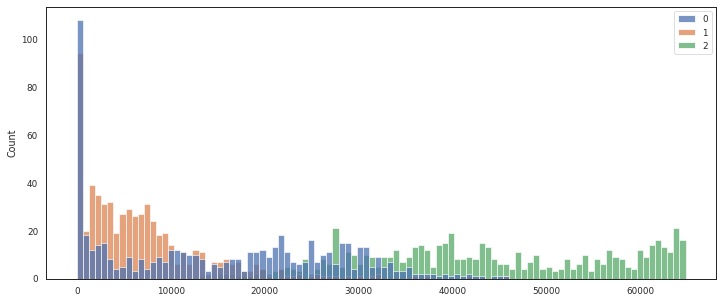

In [31]:
show_area_distributaion(FILE_PATH, VAL_SPLIT_LABEL_PATH)

### Test

In [32]:
split_filtering_save(filtering, FILE_PATH, BASE_TEST_DIR, VAL_IMG_PATH, VAL_LABEL_PATH,
                     COLOR_MAP, threshold=0)

100%|██████████| 30/30 [00:05<00:00,  5.49it/s]


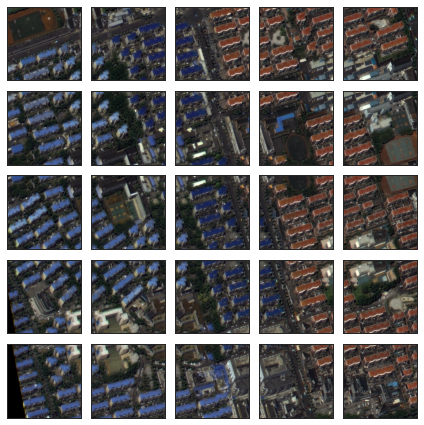

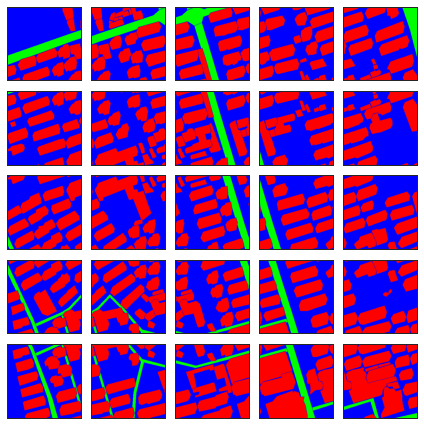

In [33]:
show_n_imgs(TEST_SPLIT_IMG_PATH, 25, 5, 5)
show_n_imgs(TEST_SPLIT_LABEL_PATH, 25, 5, 5)

## Dataset Test
---

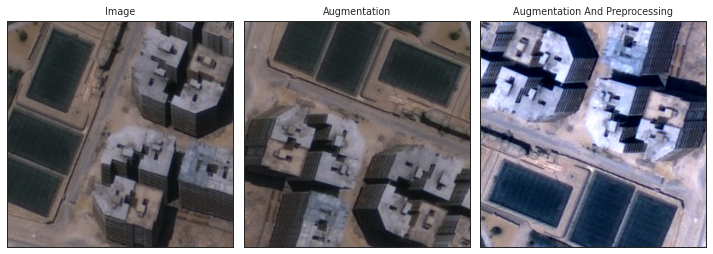

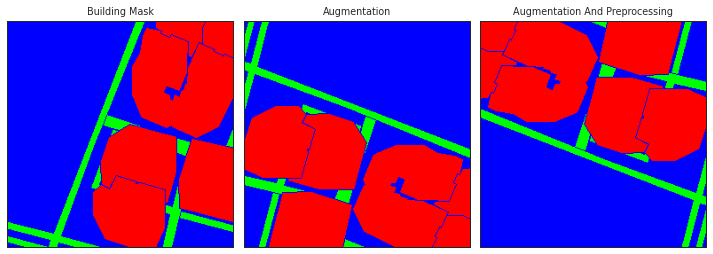

In [34]:
# Lets look at augmented data we have
dataset = SatelliteGenerator(
    FILE_PATH,
    VAL_SPLIT_IMG_PATH,
    VAL_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation()
)

dataset_aug = SatelliteGenerator(
    FILE_PATH,
    VAL_SPLIT_IMG_PATH,
    VAL_SPLIT_LABEL_PATH, 
    augmentation=get_training_augmentation())

preprocess_input = sm.get_preprocessing('efficientnetb3')
dataset_aug_pre = SatelliteGenerator(
    FILE_PATH,
    VAL_SPLIT_IMG_PATH,
    VAL_SPLIT_LABEL_PATH,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

idx = 10
image, mask = dataset[idx] # get some sample
image_aug, mask_aug = dataset_aug[idx]
image_aug_pre, mask_aug_pre = dataset_aug_pre[idx]


visualize(
    image=image[0][:, :, :3], 
    augmentation=image_aug[0][:, :, :3],
    augmentation_and_preprocessing=denormalize(image_aug_pre[0][:, :, :3])
)

visualize(
    building_mask=mask[0][:, :, :3],
    augmentation=mask_aug[0][:, :, :3],
    augmentation_and_preprocessing=mask_aug_pre[0][:, :, :3]
)

## Train
---

### E17-1

#### Train

In [53]:
lr = 1e-4
BATCH_SIZE = 8
EPOCHS=100
optim = keras.optimizers.Adam(lr=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [54]:
model_17_1, callbacks = get_model(
    'E17-1-2',
    optim,
    train_datagenerator, 
    valid_datagenerator,
    '/home/aiffel-dj1/workspace/Hackerton/workspace/Model/trained_model/E17/E17_1_2_best_model.h5')

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


In [151]:
start_time = time.time()

history_17_1 = model_17_1.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))
 
sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
836/836 [==============================] - 365s 339ms/step - loss: 0.5927 - iou_score: 0.3547 - f1-score: 0.4928 - val_loss: 0.4929 - val_iou_score: 0.4532 - val_f1-score: 0.5904
Epoch 2/100
836/836 [==============================] - 200s 240ms/step - loss: 0.4567 - iou_score: 0.4830 - f1-score: 0.6256 - val_loss: 0.4822 - val_iou_score: 0.4662 - val_f1-score: 0.5994
Epoch 3/100
836/83

InternalError:  Failed launching ResizeNearestNeighborGrad
	 [[node gradient_tape/model_1/decoder_stage1_upsampling/resize/ResizeNearestNeighborGrad (defined at <ipython-input-151-eebc1e23683e>:9) ]] [Op:__inference_train_function_54999]

Function call stack:
train_function


In [55]:
model_17_1.load_weights('/home/aiffel-dj1/workspace/Hackerton/workspace/Model/trained_model/E17/E17_1_best_model.h5')

In [112]:
start_time = time.time()

history_17_1 = model_17_1.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))
 
sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/100
836/836 [==============================] - 356s 354ms/step - loss: 0.2989 - iou_score: 0.6297 - f1-score: 0.7554 - val_loss: 0.3848 - val_iou_score: 0.5485 - val_f1-score: 0.6797
Epoch 2/100
836/836 [==============================] - 214s 256ms/step - loss: 0.2950 - iou_score: 0.6337 - f1-score: 0.7586 - val_loss: 0.3910 - val_iou_score: 0.5478 - val_f1-score: 0.6787
Epoch 3/100
836/836 [==============================] - 214s 256ms/step - loss: 0.2937 - iou_score: 0.6347 - f1-score: 0.7595 - val_loss: 0.3779 - val_iou_score: 0.5595 - val_f1-score: 0.6893
Epoch 4/100
836/836 [==============================] - 216s 258ms/step - loss: 0.2897 - iou_score: 0.6386 - f1-score: 0.7630 - val_loss: 0.3937 - val_iou_score: 0.5423 - val_f1-score: 0.6758
Epoch 5/100
836/836 [==============================] - 216s 258ms/step - loss: 0.2880 - iou_score: 0.6407 - f1-score: 0.7645 - val_loss: 0.3817 - val_iou_score: 0.5565 - val_f1-score: 0.6866
Epoch 6/100
836/836 [========================

#### evaluation

In [56]:
model_17_1.load_weights('/home/aiffel-dj1/workspace/Hackerton/workspace/Model/trained_model/E17/E17_1_2_best_model.h5')

In [35]:
preprocess_input = sm.get_preprocessing('efficientnetb3')
test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_SPLIT_IMG_PATH, 
    TEST_SPLIT_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)

In [116]:
val_metrix = model_17_1.evaluate(valid_datagenerator)
test_metrix = model_17_1.evaluate(test_datagenerator)

80/80 [==============================] - 5s 67ms/step - loss: 0.3716 - iou_score: 0.5655 - f1-score: 0.6922


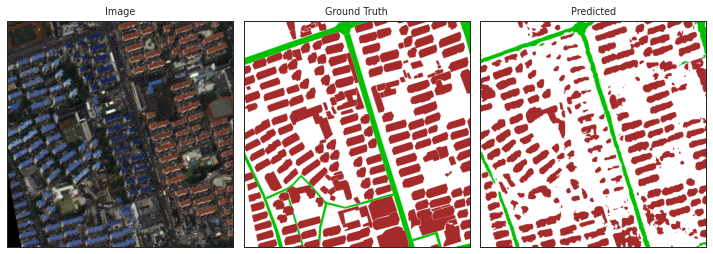

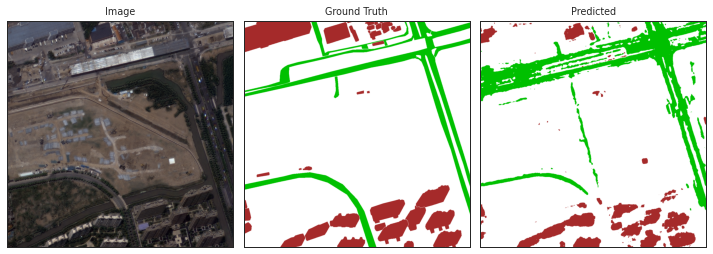

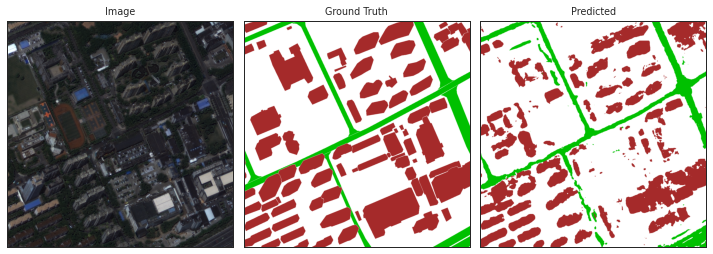

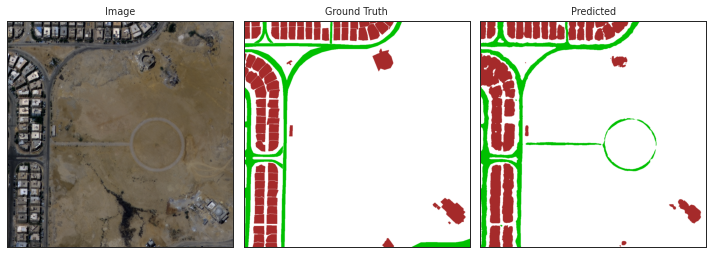

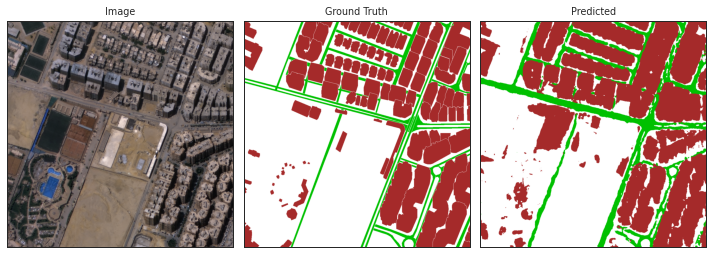

In [123]:
BACKBONE = 'efficientnetb3'
show_inference(model_17_1, get_slice_pos(25))